In [1]:
###########################################################
# Import the packages
###########################################################
import pymysql
import sys
import pandas as pd
import numpy as np
from pandasql import sqldf
%matplotlib inline 
import matplotlib.pyplot as plt
from pylab import rcParams

In [2]:
###########################################################
# Connect with database philadelphia
###########################################################

host = 'localhost'
username = 'root'
password = ''
database = 'philadelphia'

connection = pymysql.connect(host, username, password, database, charset='utf8', use_unicode=True);


In [3]:
###########################################################
# Import data from MySQL and store in pandas dataframes
###########################################################
sql = '''select * from teachers'''
sq2 = '''select * from median_house_household_income_in_philadelphia'''
sq3 = '''select * from school_scores'''
sq4 = '''select * from schools'''
sq5 = '''select * from serious_incidents'''


with connection:
    cursor = connection.cursor(pymysql.cursors.DictCursor)
    cursor.execute(sql)
    teachers = pd.DataFrame(cursor.fetchall())
    
    cursor = connection.cursor(pymysql.cursors.DictCursor)
    cursor.execute(sq2)
    median_income = pd.DataFrame(cursor.fetchall())
    
    cursor = connection.cursor(pymysql.cursors.DictCursor)
    cursor.execute(sq3)
    school_scores = pd.DataFrame(cursor.fetchall())
    
    cursor = connection.cursor(pymysql.cursors.DictCursor)
    cursor.execute(sq4)
    schools = pd.DataFrame(cursor.fetchall())
    
    cursor = connection.cursor(pymysql.cursors.DictCursor)
    cursor.execute(sq5)
    serious_incidents = pd.DataFrame(cursor.fetchall())

Text(0,0.5,'Overall Score of Schools')

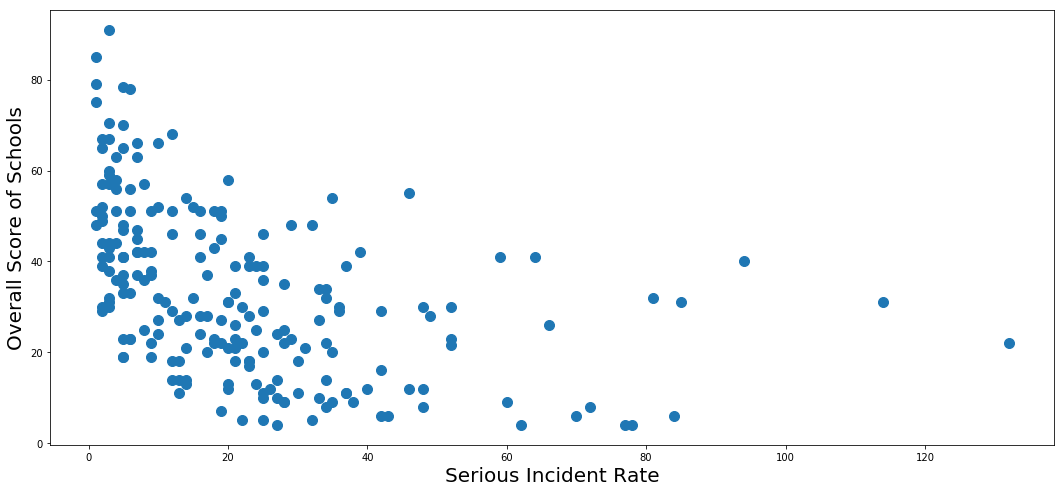

In [4]:
###########################################################
# Scatter plot of school score and serious incident rate
###########################################################

teachers=teachers[teachers['PAY_RATE_TYPE']=='SALARIED']

sql= """
select serious_incidents.Incident_Count*1000/school_scores.Enrollment as Rate,avg(school_scores.Overall_score) as Score
from schools,school_scores,serious_incidents
where schools.SRC_ID=school_scores.SRC_ID 
and serious_incidents.SRC_ID=schools.SRC_ID
group by serious_incidents.SRC_ID
"""

temp = sqldf(sql, globals())

plot=temp.plot(kind='scatter', x='Rate', y='Score', grid=False,figsize=(18,8),s=100)
plot.set_xlabel("Serious Incident Rate",size=20)
plot.set_ylabel("Overall Score of Schools",size=20)

Text(0,0.5,'Overall Score of Schools')

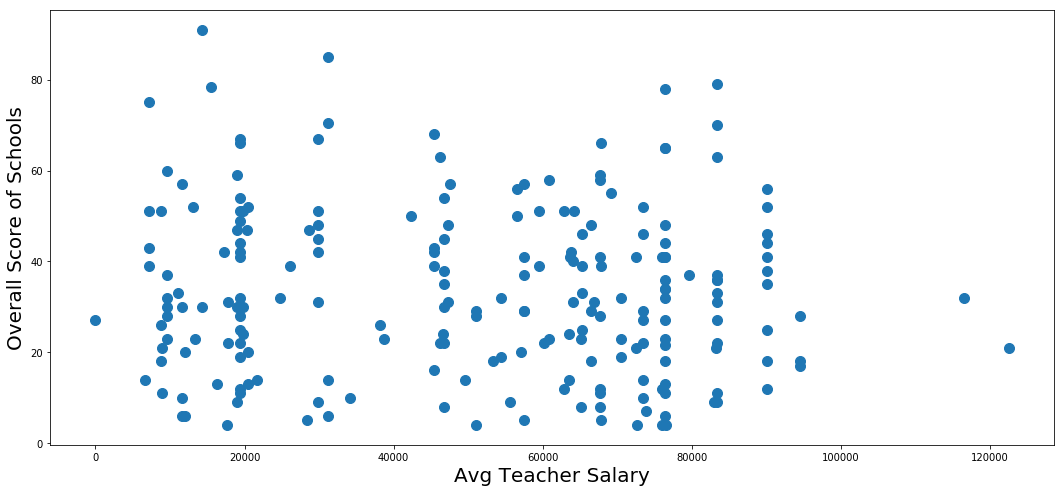

In [5]:
###########################################################
# Scatter plot of school score and teacher salary
###########################################################
teachers=teachers[teachers['PAY_RATE_TYPE']=='SALARIED']

sql= """
select teachers.PAY_RATE as Pay,avg(school_scores.Overall_score) as Score
from teachers,schools,school_scores
where schools.ULCS_CODE=teachers.ULCS_CODE and school_scores.SRC_ID=schools.SRC_ID
group by teachers.ULCS_CODE
"""
temp = sqldf(sql, globals())


plot=temp.plot(kind='scatter', x='Pay', y='Score', grid=False,figsize=(18,8),s=100)
plot.set_xlabel("Avg Teacher Salary",size=20)
plot.set_ylabel("Overall Score of Schools",size=20)

Text(0,0.5,'Overall Score of Schools')

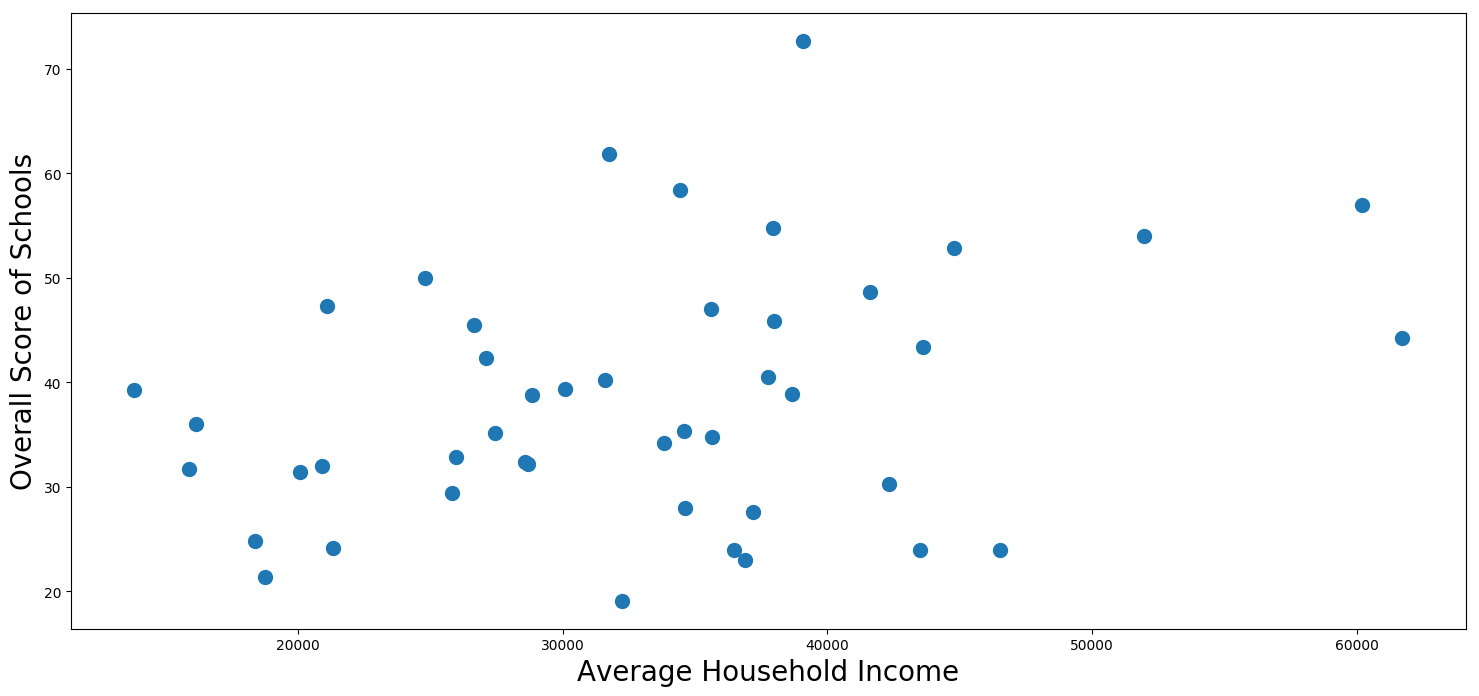

In [6]:
###########################################################
# Scatter plot of school score and average household income
###########################################################
sql= """
select median_income.Avg_Income_Household as Income,avg(school_scores.Overall_score) as Score
from median_income,schools, school_scores
where schools.ZIP_CODE=median_income.ZIP_CODE and school_scores.SRC_ID=schools.SRC_ID
group by median_income.ZIP_CODE
"""
temp = sqldf(sql, globals())

plt.style.use(u'default')
plot=temp.plot(kind='scatter', x='Income', y='Score', grid=False,figsize=(18,8),s=100)
plot.set_xlabel("Average Household Income",size=20)
plot.set_ylabel("Overall Score of Schools",size=20)


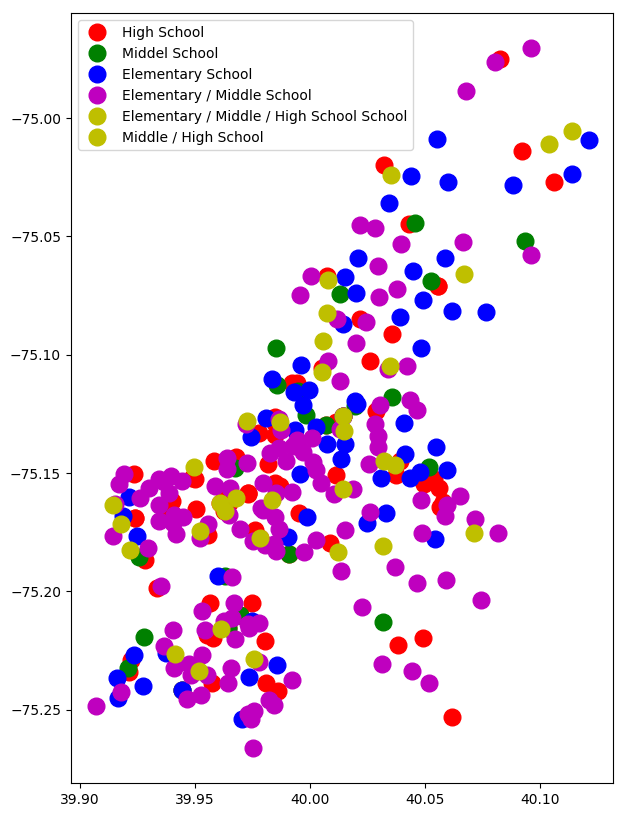

In [7]:
###########################################################
# A map of schools, color = school type
###########################################################
latitude=[]
longitude=[]
for i in schools["GPS_LOCATION"]:
    latitude.append(i[:i.index(" ")])
    longitude.append(i[i.index(" "):])

schools["latitude"]=pd.to_numeric(latitude)
schools["longitude"]=pd.to_numeric(longitude)

school_1=schools["SCHOOL_LEVEL"]=='HIGH'
school_2=schools["SCHOOL_LEVEL"]=='MIDDLE'
school_3=schools["SCHOOL_LEVEL"]=='ELEMENTARY'
school_4=schools["SCHOOL_LEVEL"]=='ELEMENTARYMIDDLE'
school_5=schools["SCHOOL_LEVEL"]=='ELEMENTARYMIDDLEHIGH'
school_6=schools["SCHOOL_LEVEL"]=='MIDDLEHIGH'


plt.rcParams["figure.figsize"] = [7,10]
plt.plot(schools[school_1].latitude,schools[school_1].longitude, 'ro',ms=12,label='High School')
plt.plot(schools[school_2].latitude,schools[school_2].longitude, 'go',ms=12,label='Middel School')
plt.plot(schools[school_3].latitude,schools[school_3].longitude, 'bo',ms=12,label='Elementary School')
plt.plot(schools[school_4].latitude,schools[school_4].longitude, 'mo',ms=12,label='Elementary / Middle School')
plt.plot(schools[school_5].latitude,schools[school_5].longitude, 'yo',ms=12,label='Elementary / Middle / High School School')
plt.plot(schools[school_6].latitude,schools[school_6].longitude, 'yo',ms=12,label='Middle / High School')
plt.legend()
 

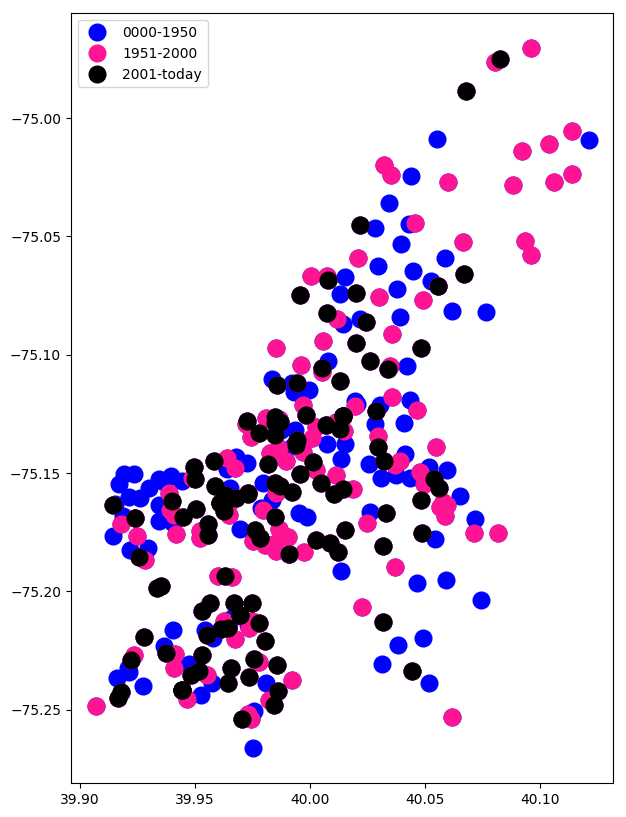

In [8]:
###########################################################
# A map of schools, color = foundation year
###########################################################
schools["YEAR_OPENED"]=pd.to_numeric(schools["YEAR_OPENED"])
plt.rcParams["figure.figsize"] = [7,10]
school_1=schools["YEAR_OPENED"]>1000
school_2=schools["YEAR_OPENED"]>1950
school_3=schools["YEAR_OPENED"]>2000

plt.plot(schools[school_1].latitude,schools[school_1].longitude,'o',ms=12,label='0000-1950',c='b')
plt.plot(schools[school_2].latitude,schools[school_2].longitude,'o',ms=12,label='1951-2000',c='deeppink')
plt.plot(schools[school_3].latitude,schools[school_3].longitude,'o',ms=12,label='2001-today',c='black')
plt.legend()

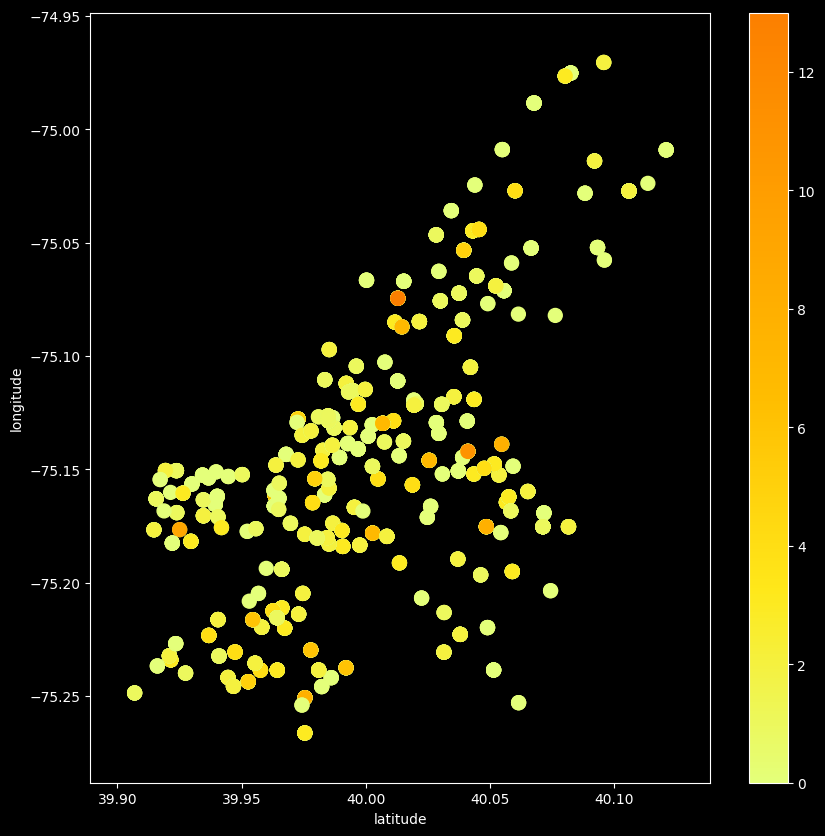

In [9]:
###########################################################
# A map of schools, color = incident rate
###########################################################
sql= """
select schools.latitude,schools.longitude,serious_incidents.Incident_Count*100/school_scores.Enrollment as Rate
from schools,school_scores,serious_incidents
where schools.SRC_ID=school_scores.SRC_ID and serious_incidents.SRC_ID=schools.SRC_ID
"""
temp = sqldf(sql, globals())
plt.style.use(u'dark_background')
plot=temp.plot(kind='scatter', x='latitude', y='longitude', grid=False,figsize=(10,10),s=100,c=temp.Rate ,cmap='Wistia')



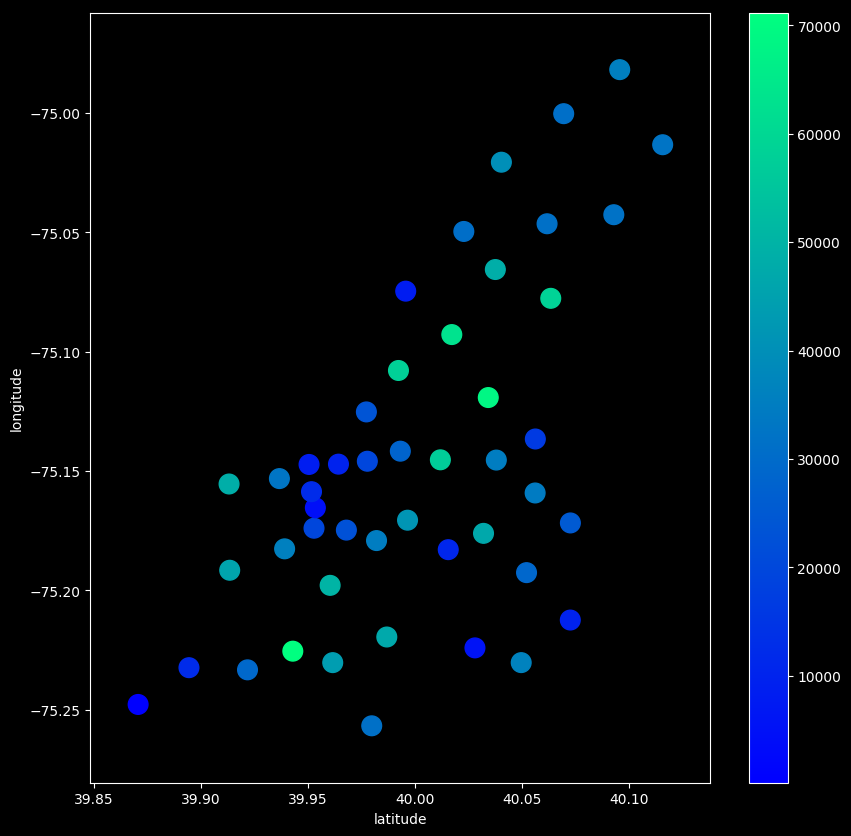

In [10]:
###########################################################
# A map zip codes, color = household income
###########################################################
latitude=[]
longitude=[]
for i in median_income["Location"]:
    latitude.append(i[:i.index("\\")])
    longitude.append(i[i.index("\\")+2:])
    
median_income["latitude"]=pd.to_numeric(latitude)
median_income["longitude"]=pd.to_numeric(longitude)

#plt.plot(median_income.latitude,median_income.longitude,'ro',ms=12, size=median_income.Population)
plt.style.use(u'dark_background')
median_income.plot(kind='scatter', x='latitude', y='longitude',grid=False,  figsize=(10,10), c=median_income.Population,s=200,cmap='winter')
    

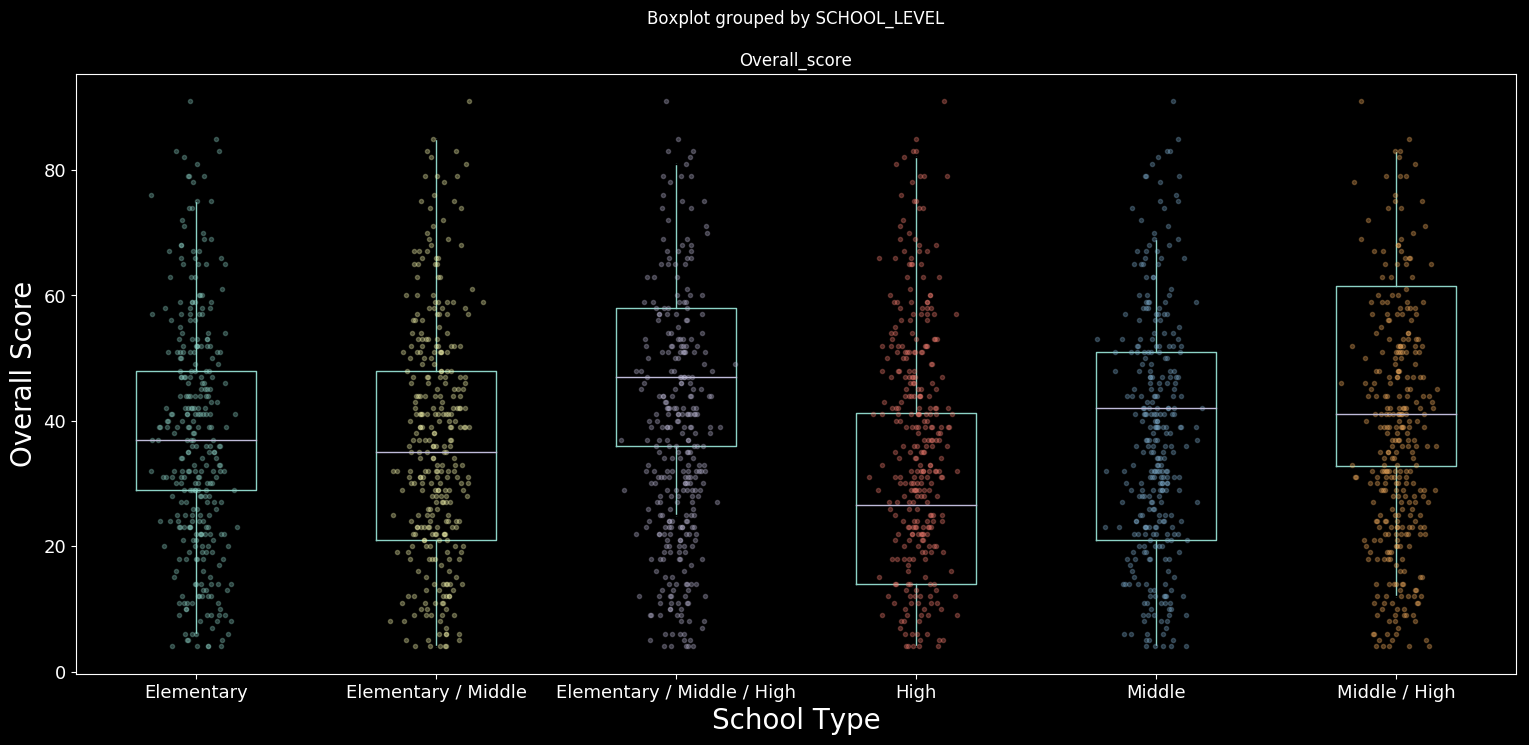

In [11]:
###########################################################
# A boxplot of school scores and school types
###########################################################
sql='''select Overall_score, SCHOOL_LEVEL from school_scores as ss , schools as s where ss.SRC_ID = s.SRC_ID'''

with connection:
    cursor = connection.cursor(pymysql.cursors.DictCursor)
    cursor.execute(sql)
    score_by_schooltype = pd.DataFrame(cursor.fetchall())

    
score_by_schooltype["Overall_score"]=pd.to_numeric(score_by_schooltype["Overall_score"])
plot=score_by_schooltype.boxplot(column='Overall_score', by='SCHOOL_LEVEL', grid=False, figsize = (18,8),fontsize=13)
plot.set_xlabel("School Type",size=20)
plot.set_ylabel("Overall Score",size=20)
plt.xticks([1, 2, 3, 4, 5, 6], ['Elementary', 'Elementary / Middle', 'Elementary / Middle / High','High', 'Middle', 'Middle / High'])
plt.style.use(u'default')


for i in [1,2,3,4,5,6]:
    y = score_by_schooltype.Overall_score
    x = np.random.normal(i, 0.07, size=len(y))
    plt.plot(x, y, '.', alpha=0.3)


Text(0,0.5,'Longitude')

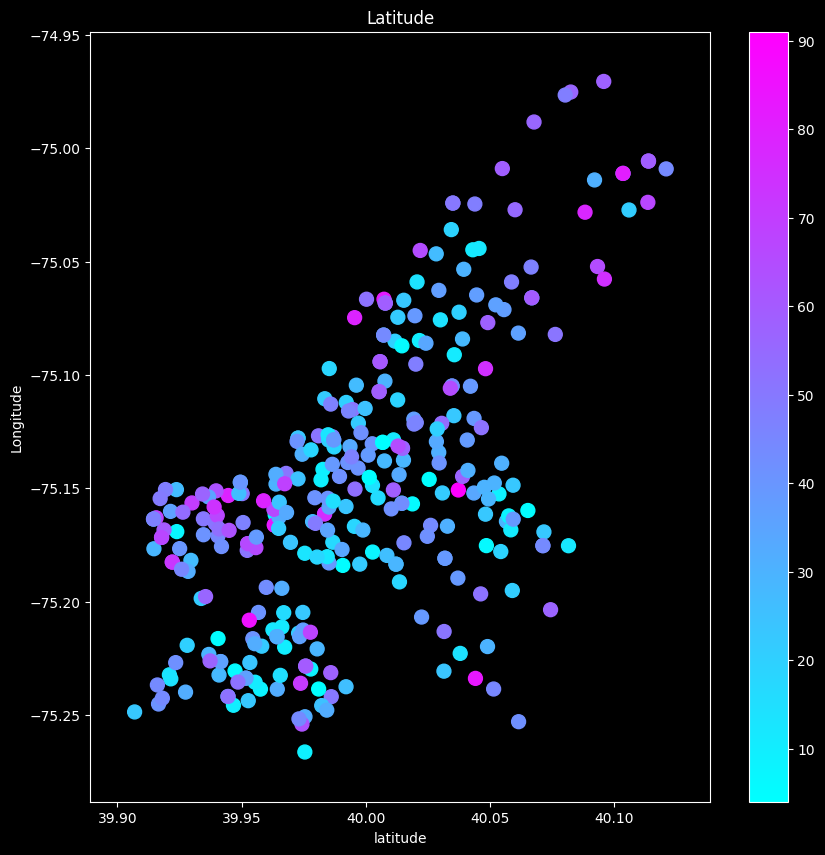

In [12]:
###########################################################
# A map of schools, color = school score
###########################################################
sql= """
select schools.latitude,schools.longitude,school_scores.Overall_Score
from schools,school_scores
where schools.SRC_ID=school_scores.SRC_ID
"""
temp = sqldf(sql, globals())

temp["Overall_Score"]=pd.to_numeric(temp["Overall_Score"])
plt.style.use(u'dark_background')
temp.plot(kind='scatter', x='latitude', y='longitude',grid=False,figsize=(10,10),s=100,c=(temp.Overall_Score),cmap='cool')
plt.title('Latitude')
plt.ylabel('Longitude')


/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


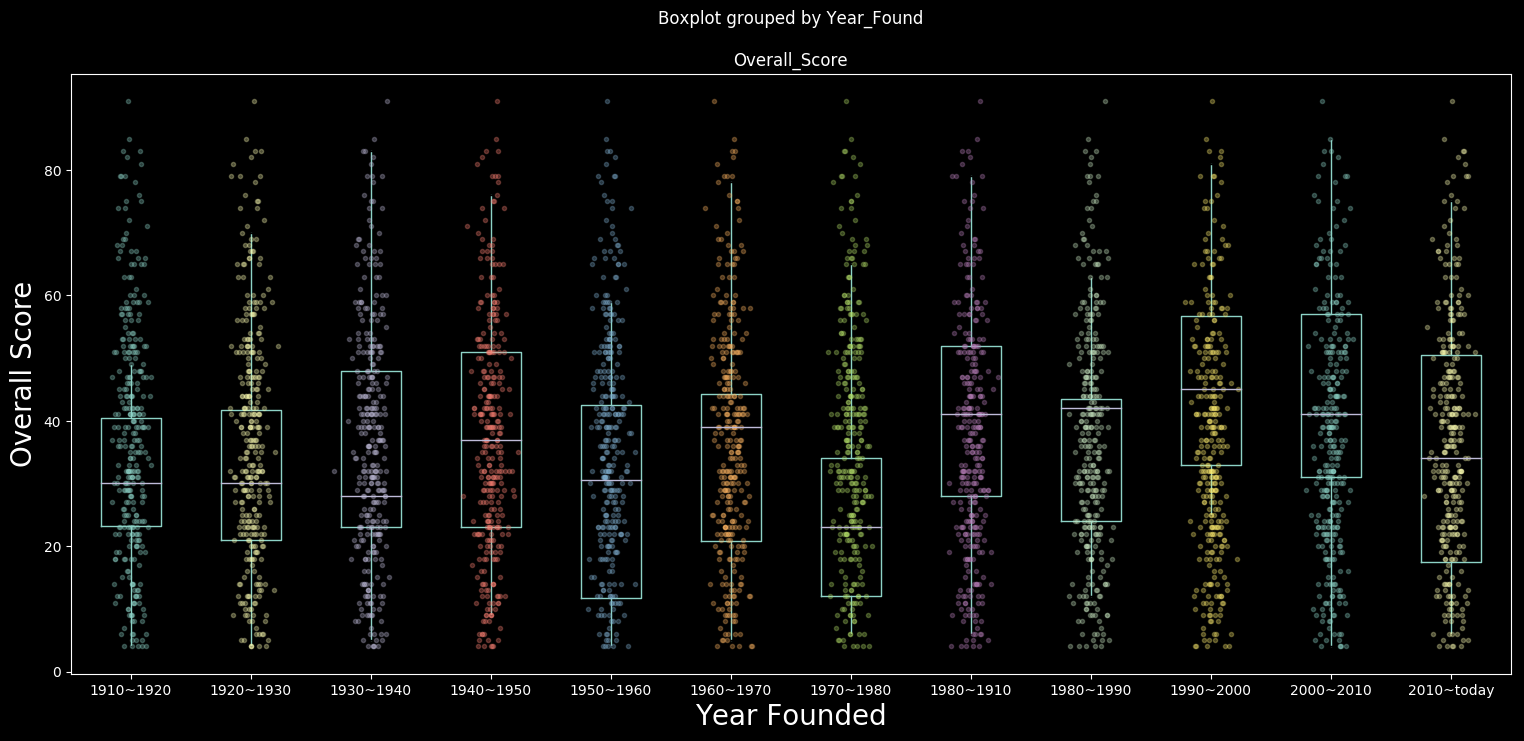

In [13]:
###########################################################
# A boxplot of school overall scores, divided by foundation year
###########################################################
list=[]
for i in schools["YEAR_OPENED"]:
    if i<1910:
        list.append("1980~1910")
    elif i<1920:
        list.append("1910~1920")
    elif i<1930:
        list.append("1920~1930")
    elif i<1940:
        list.append("1930~1940")
    elif i<1950:
        list.append("1940~1950")
    elif i<1960:
        list.append("1950~1960")
    elif i<1970:
        list.append("1960~1970")
    elif i<1980:
        list.append("1970~1980")
    elif i<1990:
        list.append("1980~1990")
    elif i<2000:
        list.append("1990~2000")
    elif i<2010:
        list.append("2000~2010")
    else:
        list.append("2010~today")
schools["Year_Found"]=list

sql= """
select schools.Year_Found,school_scores.Overall_Score
from schools,school_scores
where schools.SRC_ID=school_scores.SRC_ID
"""
temp = sqldf(sql, globals())
temp["Overall_Score"]=pd.to_numeric(temp["Overall_Score"])
plt.rcParams["figure.figsize"] = [18,8]
plot=temp.boxplot(column="Overall_Score",by="Year_Found",grid='false')
plt.style.use(u'default')
plot.set_xlabel("Year Founded",size=20)
plot.set_ylabel("Overall Score",size=20)
for i in [1,2,3,4,5,6,7,8,9,10,11,12]:
    y = temp.Overall_Score
    x = np.random.normal(i, 0.07, size=len(y))
    plt.plot(x, y, '.', alpha=0.3)

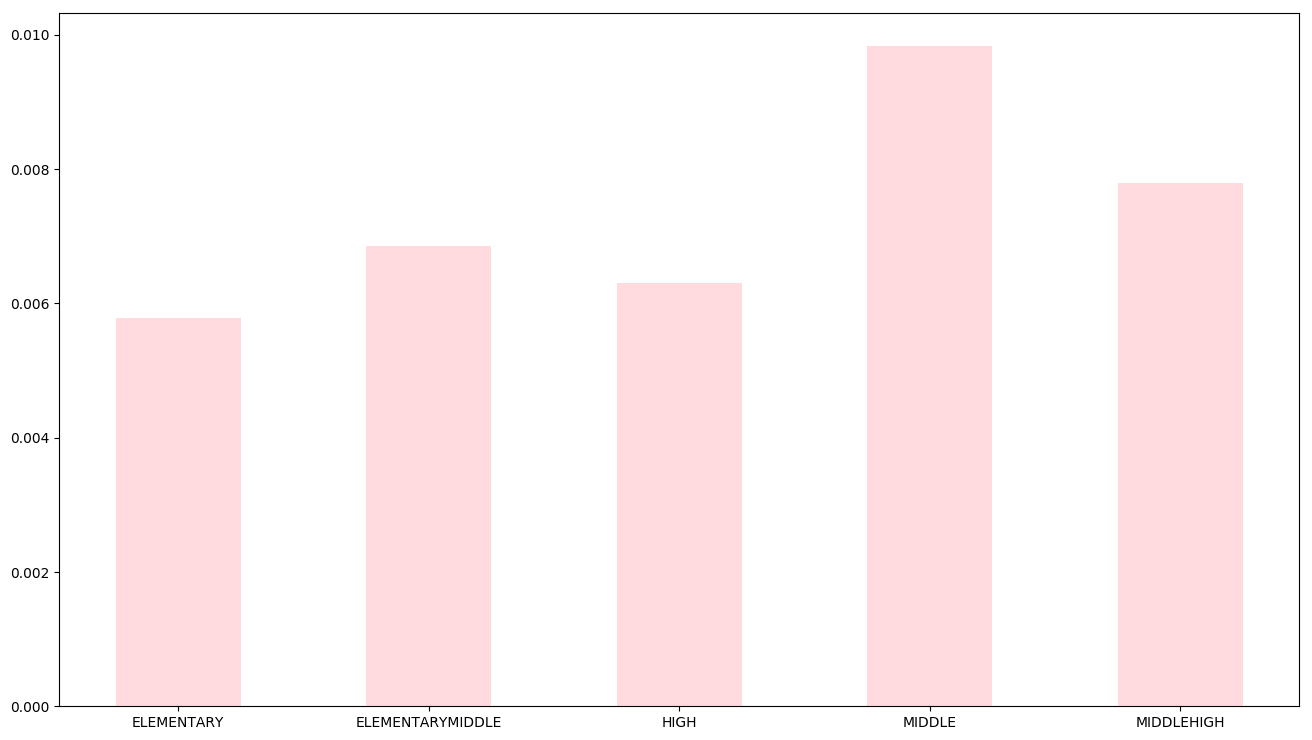

In [14]:
###########################################################
# A bar chart of incident rate by school type
# (incident rate = incident_count / enrollment)
###########################################################
sql= """
select 
schools.SCHOOL_LEVEL as Level,
sum(school_scores.Enrollment) as Enroll,
sum(serious_incidents.Incident_Count) as Incident

from schools,serious_incidents,school_scores

where schools.SRC_ID=serious_incidents.SRC_ID and school_scores.SRC_ID=schools.SRC_ID

group by schools.SCHOOL_LEVEL
"""

temp = sqldf(sql, globals())
temp["Rate"]=temp["Incident"]/temp["Enroll"]
plt.figure(figsize=(16,9))
rects1 = plt.bar(temp.Level, temp.Rate,
                 alpha=0.5,
                 color='lightpink',
                 label='Frank',
                 width=0.5)


Text(0,0.5,'Year Founded')

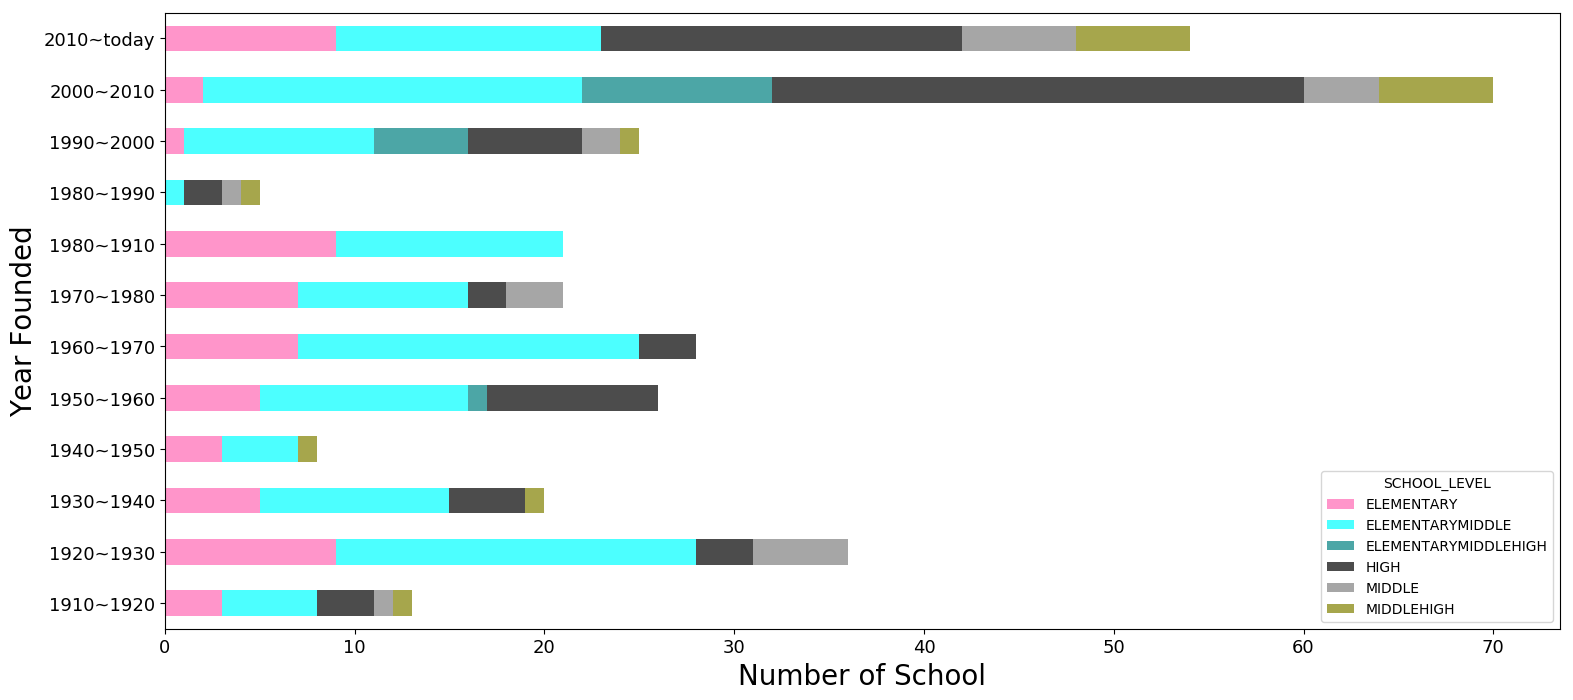

In [15]:
###########################################################
# Stacked bar chart of school type vs. year found
###########################################################
found_counts = pd.crosstab(schools.Year_Found, schools.SCHOOL_LEVEL)
plot=found_counts.plot(kind='barh', stacked=True, grid=False,figsize=(18,8),alpha=0.7,fontsize=13,color=['hotpink','cyan','teal','k','grey','olive'])
plt.style.use(u'default')
plot.set_xlabel("Number of School",size=20)
plot.set_ylabel("Year Founded",size=20)

Text(0,0.5,'Year Founded')

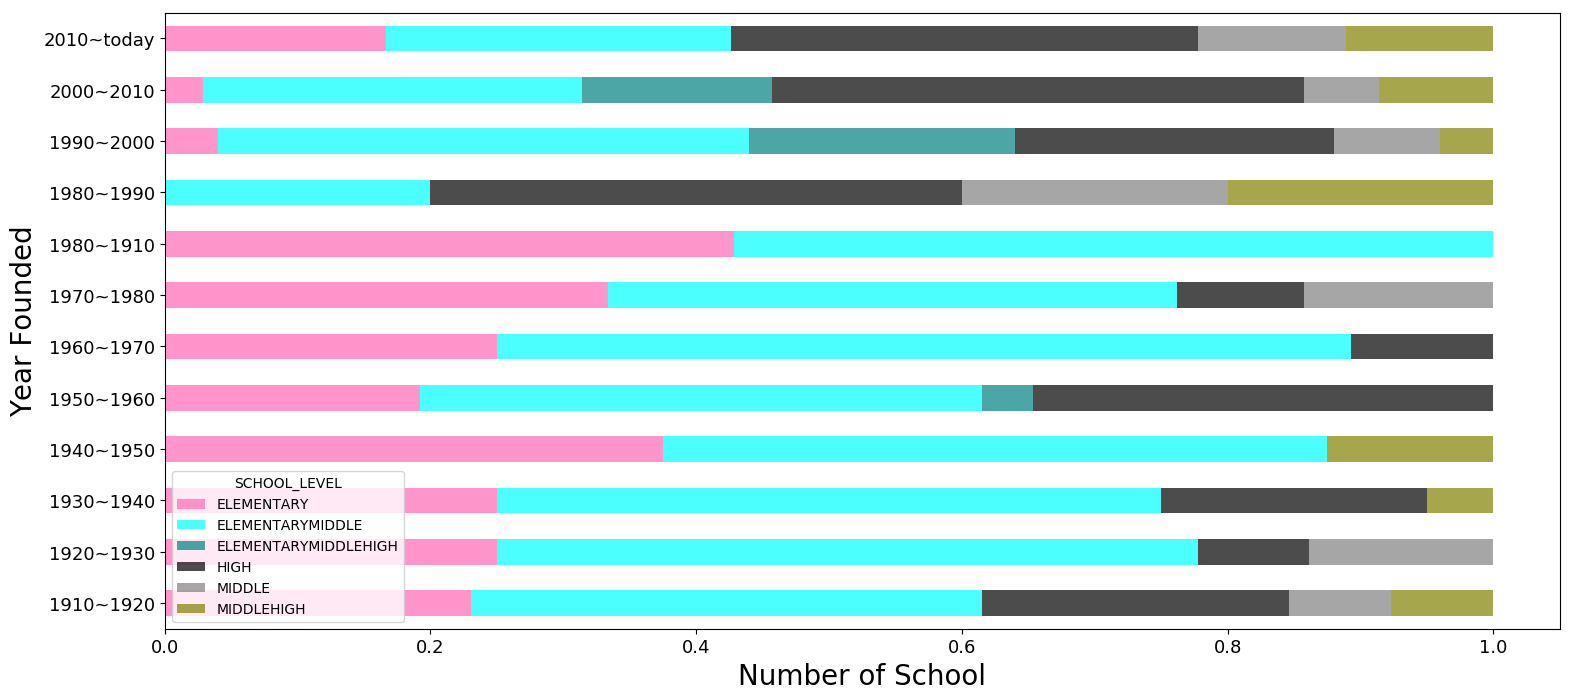

In [16]:
plot=found_counts.div(found_counts.sum(1).astype(float), axis=0).plot(kind='barh', stacked=True, grid=False,figsize=(18,8),alpha=0.7,\
                  color=['hotpink','cyan','teal','k','grey','olive'],fontsize=13)
plot.set_xlabel("Number of School",size=20)
plot.set_ylabel("Year Founded",size=20)

Text(0,0.5,'Incident Type')

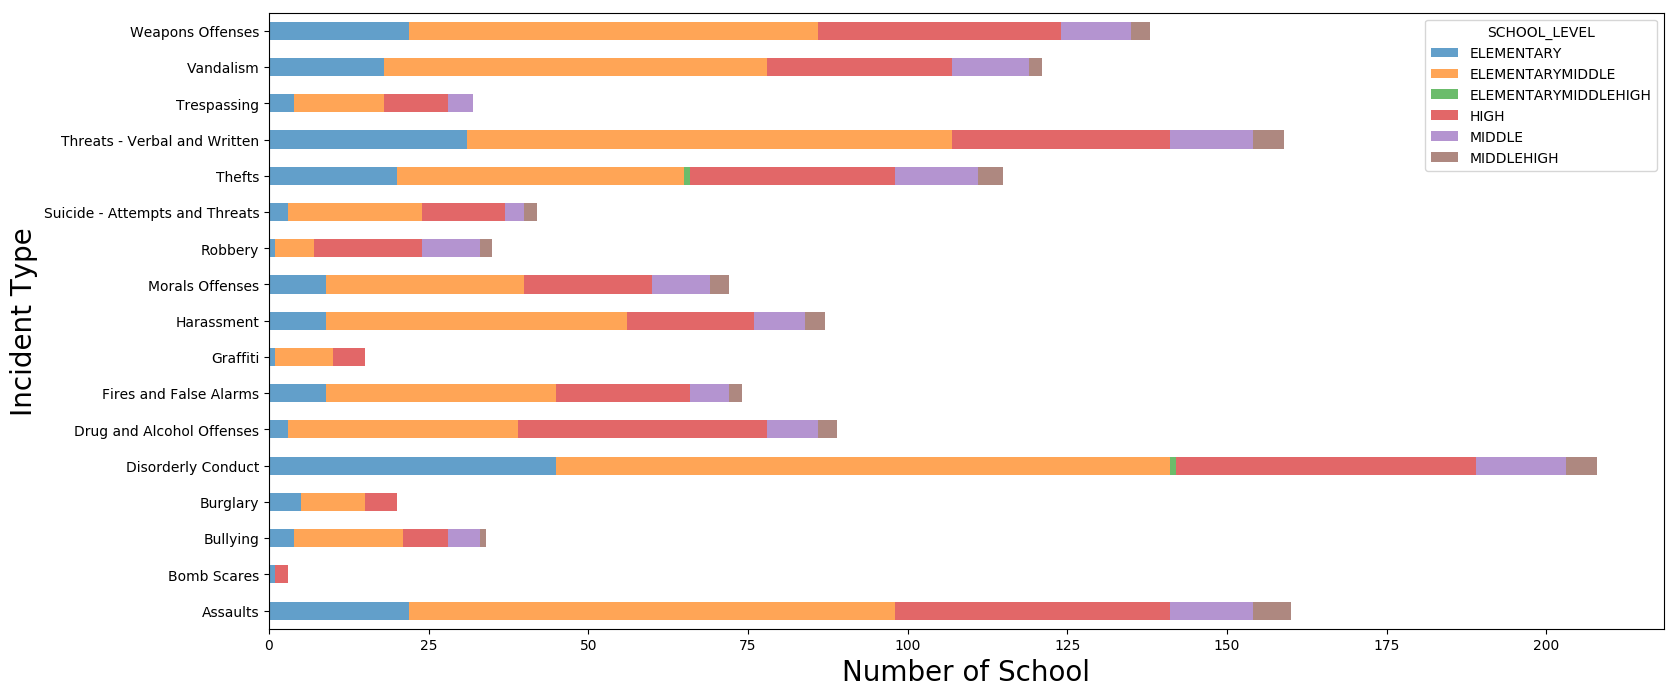

In [17]:
###########################################################
# Stacked bar chart of incident type vs. school type 
###########################################################
sql= """
select serious_incidents.Incident_Type,schools.SCHOOL_LEVEL,serious_incidents.Incident_Count as cnt
from serious_incidents,schools
where serious_incidents.SRC_ID=schools.SRC_ID
"""
temp = sqldf(sql, globals())
temp

#temp.pivot(index='Incident_Type', columns='SCHOOL_LEVEL', values='cnt')

found_counts = pd.crosstab(temp.Incident_Type, temp.SCHOOL_LEVEL)
plot=found_counts.plot(kind='barh', stacked=True, grid=False,figsize=(18,8),alpha=0.7)
plot.set_xlabel("Number of School",size=20)
plot.set_ylabel("Incident Type",size=20)

Text(0,0.5,'Incident Type')

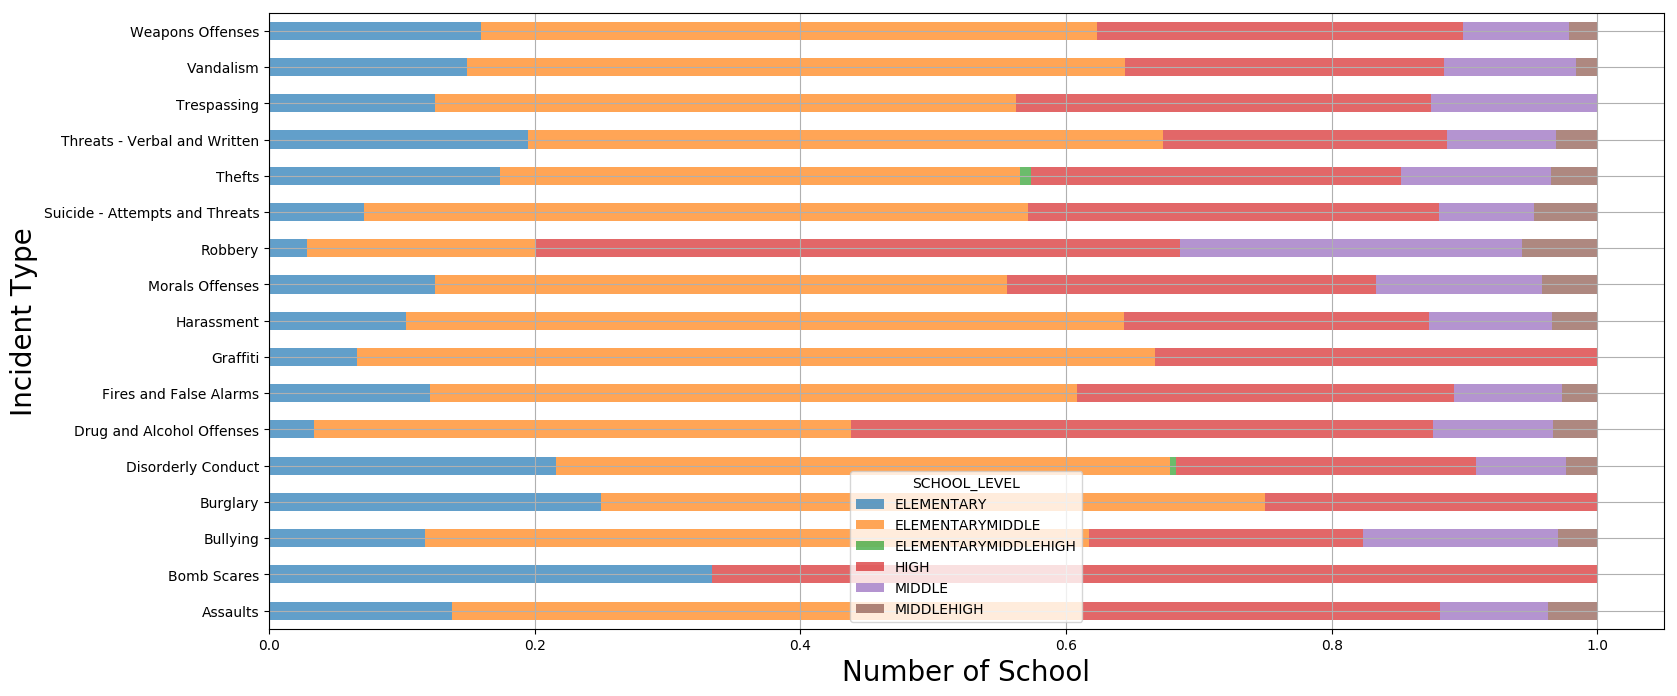

In [18]:
plot=found_counts.div(found_counts.sum(1).astype(float), axis=0).plot(kind='barh', stacked=True, grid=True,figsize=(18,8),alpha=0.7)
plot.set_xlabel("Number of School",size=20)
plot.set_ylabel("Incident Type",size=20)

Text(0,0.5,'Serious Incident Count')

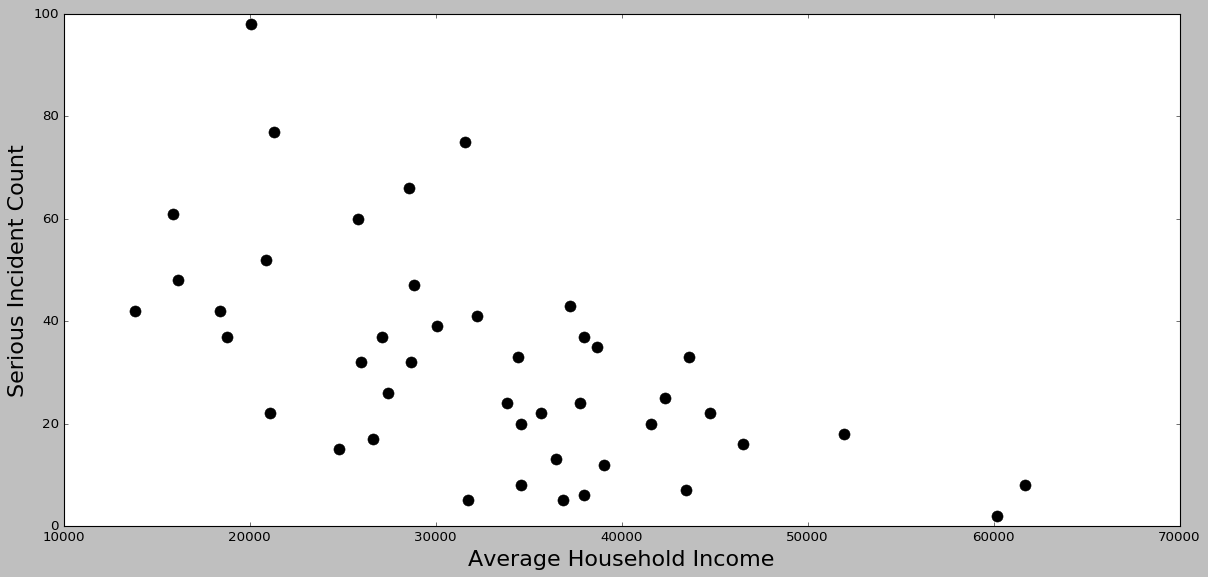

In [19]:
###########################################################
# Scatter plot of household income vs. Incident rate
###########################################################
sql= """
select median_income.Avg_Income_Household as Income, count(*) as Incident
from median_income,serious_incidents,schools
where median_income.ZIP_CODE=schools.ZIP_CODE and
schools.SRC_ID=serious_incidents.SRC_ID
group by Income
"""
temp = sqldf(sql, globals())
plt.style.use(u'classic')
plt.figure(figsize=(18,8))
plt.plot(temp.Income,temp.Incident,'ko',markersize=10)
plt.xlabel('Average Household Income',fontsize=20)
plt.ylabel('Serious Incident Count', fontsize=20)



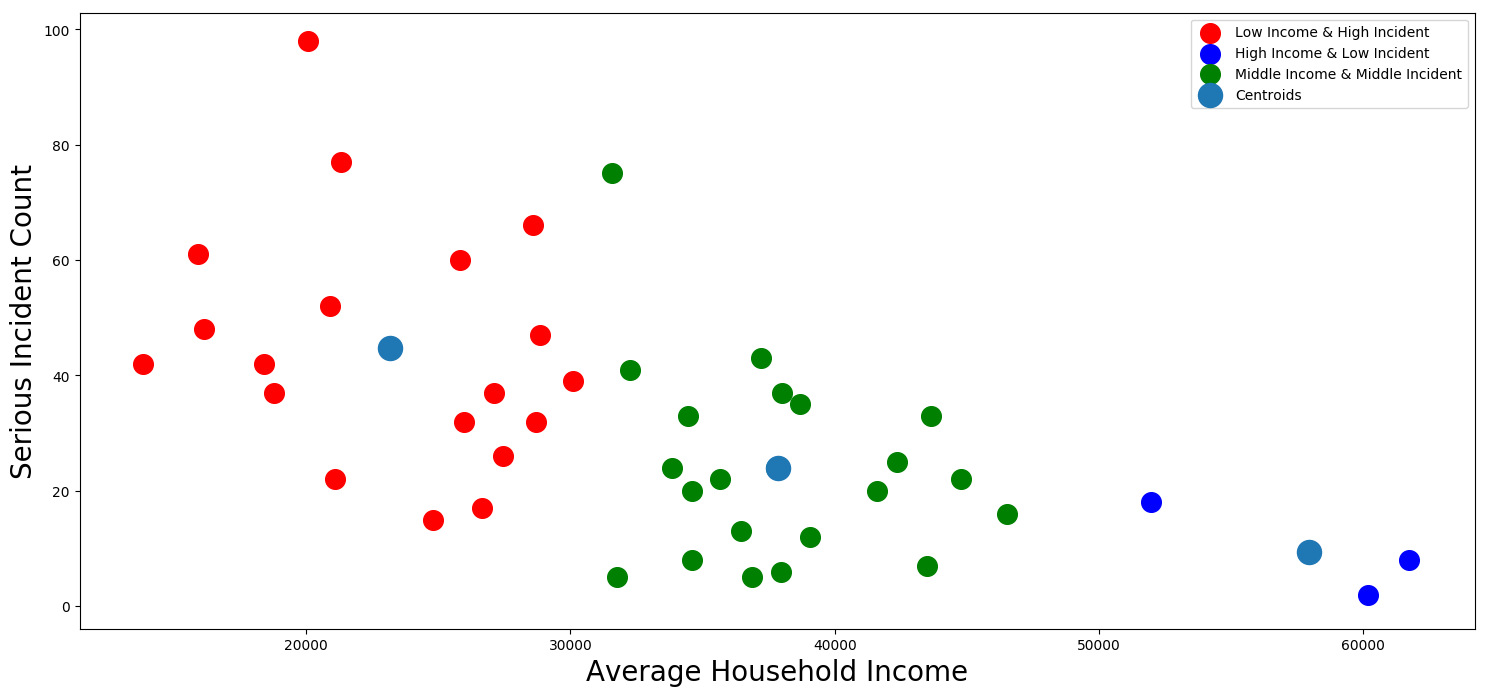

In [20]:
###########################################################
# Scatter plot of household income vs. Incident rate: use clustering technique to classifiy them
###########################################################
from sklearn.cluster import KMeans

X = temp.iloc[:, :].values

# Fitting K-Means to the dataset
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X)

# Visualising the clusters
plt.style.use(u'default')
plt.figure(figsize=(18,8))
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 200, c = 'red', label = 'Low Income & High Incident')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 200, c = 'blue', label = 'High Income & Low Incident')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 200, c = 'green', label = 'Middle Income & Middle Incident')

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, label = 'Centroids')
plt.xlabel('Average Household Income',fontsize=20)
plt.ylabel('Serious Incident Count', fontsize=20)
plt.legend()
plt.show()